# Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
Displacement and acceleration timeseries are derived.

We verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].

References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


---

# N-layers Embedded OU processes: Viggiano et al. 2020 

We generate timeseries corresponding to their equations (2.14-2.18).

- Theoritical behaviour of PSD, autocorrrelation
- Generated times series VS theorical functions fit
- Parseval verification

In [1]:
import os
import xarray as xr
import numpy as np
from scipy.special import erfc, erf


import matplotlib.pyplot as plt
from cycler import cycler

import viggiano_2020 as vig
import plot as fplt
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

from GDP_lib import root_dir


In [2]:
path = os.path.join(root_dir, "synthetic_traj_ou_taueta.zarr")
ds = xr.open_zarr(path, decode_timedelta=False)# tau_eta=1
ds

<xarray.Dataset>
Dimensions:    (T: 4, tau_eta: 5, draw: 10, freq_time: 2400, time: 24000,
                lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * tau_eta    (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Eu         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Ex         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    a          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    aa         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
    u          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    uu         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
    x          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    xx         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  [0.020833333333333332, 0.041666666666666664, 0.08333333333...

In [3]:
colors = get_cmap_colors(max(ds.T.size,ds.tau_eta.size), cmap="plasma")
plt.rc('axes', prop_cycle=cycler(color=colors))

________
## Verify viggiano bib :  CV pour n=1 -> OK

In [4]:
a = vig.PSDu_1_ds(ds)
b = vig.PSDu_n(ds.freq_time*2*np.pi,
            ds.attrs["sigma_u"],
            ds.T, 
            ds['tau_eta'], n=1)

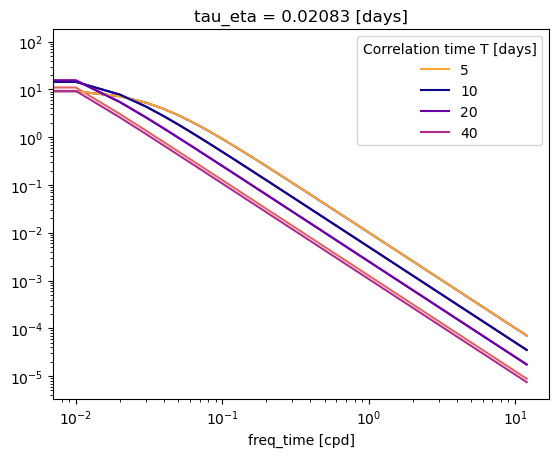

In [5]:
a.plot(hue='T')
b.isel(tau_eta=0).plot(hue='T')
plt.xscale('log')
plt.yscale('log')

________________
## Theoritical behaviour of PSD, autocorrrelation

In [8]:
def add_theoritical_func(ds):
    ds['PSDu'] = vig.PSDu_n_ds(ds)
    ds['PSDa'] = vig.PSDa_n_ds(ds)
    ds['PSDu_exp'] = vig.PSDu_1_ds(ds)
    ds['PSDa_exp'] = vig.PSDa_1_ds(ds)
    ds['coru_inf'] = vig.Coru_inf_ds(ds)
    ds['cora_inf'] = vig.Cora_inf_ds(ds)
add_theoritical_func(ds)
ds

<xarray.Dataset>
Dimensions:    (T: 4, tau_eta: 5, draw: 10, freq_time: 2400, time: 24000,
                lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * tau_eta    (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/15)
    Ea         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Eu         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Ex         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    a          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    aa         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
    u          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    ...         ...
    PSDu       (T, tau_eta, freq_time) float64 4.912e-07 4.944e-07 ... 3.069e-23
    PSDa       (T, tau_eta, freq_time) float64 3.741e-13 3.759e-13 ... 2.333e-29
    PSDu_exp   (T, freq_time) float64 7.036e-05 7.048e-05 ... 8.825e-06 8.81e-06
    PSDa_exp   (T, freq_time) float64 5.358e-11 5.358e-11 ... 6.698e-12
    coru_inf   (lags, T, tau_eta) float64 1.0 1.0 1.0 ... 1.431e-11 1.473e-11
    cora_inf   (T, tau_eta, lags) float64 7.236e-10 2.628e-10 ... -1.234e-24
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  [0.020833333333333332, 0.041666666666666664, 0.08333333333...

### Dependance on tau_eta
CV to the PSD for n=1 when $\tau_{\eta} \rightarrow 0$ ?

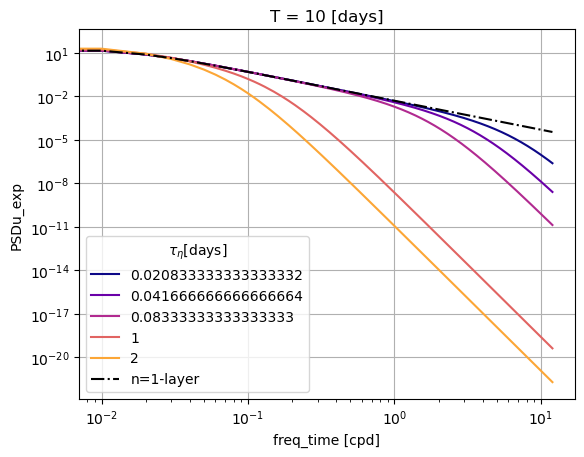

In [5]:
ds.PSDu.isel(T=1).plot(hue='tau_eta', label=ds.attrs['tau_eta_days'])
ds.PSDu_exp.isel(T=1).plot(color='k', ls='-.', label='n=1-layer')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(title=r'$\tau_{\eta}$[days]')

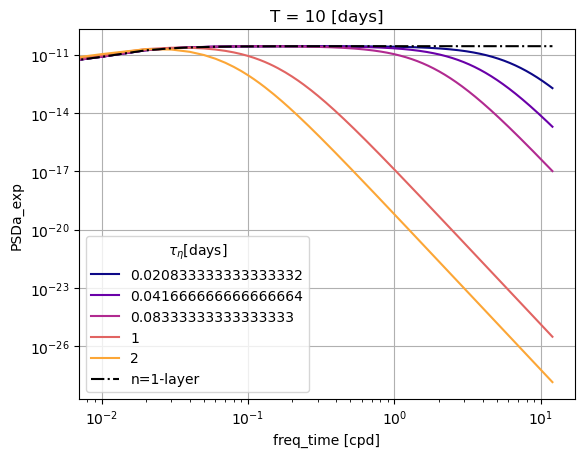

In [6]:
ds.PSDa.isel(T=1).plot(hue='tau_eta', label=ds.attrs['tau_eta_days'])
ds.PSDa_exp.isel(T=1).plot(color='k', ls='-.', label='n=1-layer')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(title=r'$\tau_{\eta}$[days]')

### Dependance on T

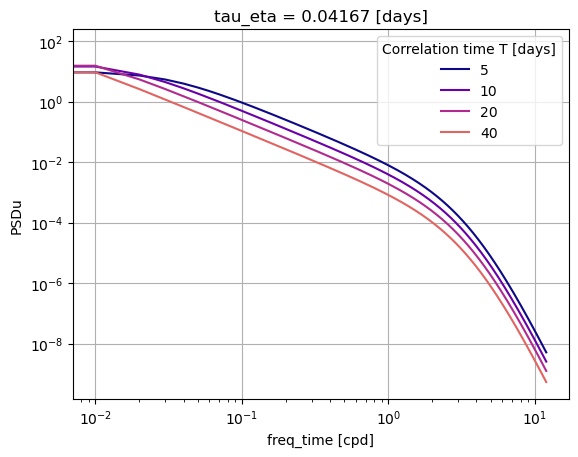

In [7]:
ds.PSDu.isel(tau_eta=1).plot(hue='T')
plt.grid()
plt.xscale('log')
plt.yscale('log')

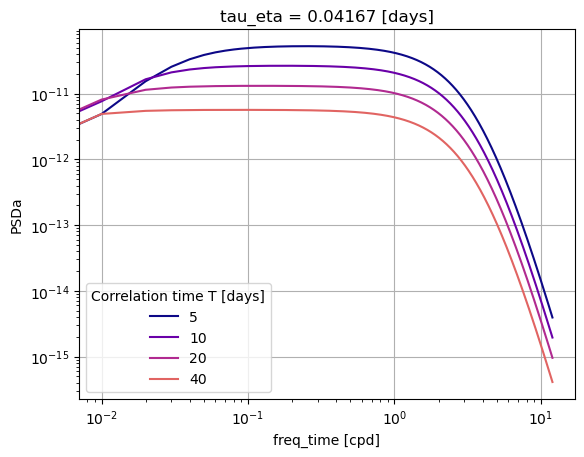

In [8]:
ds.PSDa.isel(tau_eta=1).plot(hue='T')
plt.grid()
plt.xscale('log')
plt.yscale('log')

### Mixed dependence

Text(0.5, 1.0, '')

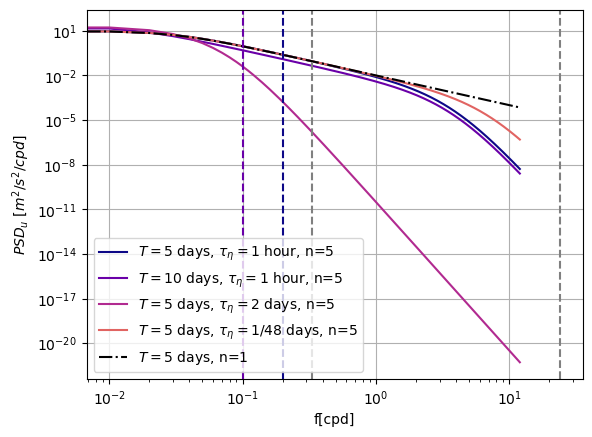

In [9]:
ds.PSDu.sel(T=5, tau_eta=1/24).plot(color = colors[0],label=r'$T=5$ days, $\tau_{\eta}=1$ hour, n=5')
ds.PSDu.sel(T=10, tau_eta=1/24).plot(color = colors[1],label=r'$T=10$ days, $\tau_{\eta}=1$ hour, n=5')
ds.PSDu.sel(T=5, tau_eta=2).plot(color = colors[2],label=r'$T=5$ days, $\tau_{\eta}=2$ days, n=5')
ds.PSDu.sel(T=5, tau_eta=1/48).plot(color = colors[3],label=r'$T=5$ days, $\tau_{\eta}=1/48$ days, n=5')
ds.PSDu_exp.sel(T=5).plot(color = 'k', ls='-.', label=r'$T=5$ days, n=1')

plt.axvline(1/5, ls='--', color = colors[0])
plt.axvline(1/10, ls='--', color = colors[1])
plt.axvline(24, ls='--', color = 'grey')
plt.axvline(1/3, ls='--', color = 'grey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f[cpd]')
plt.ylabel(r'$PSD_u$ $[m^2/s^2/cpd]$')
plt.grid()
plt.legend()
plt.title('')

Text(0.5, 1.0, '')

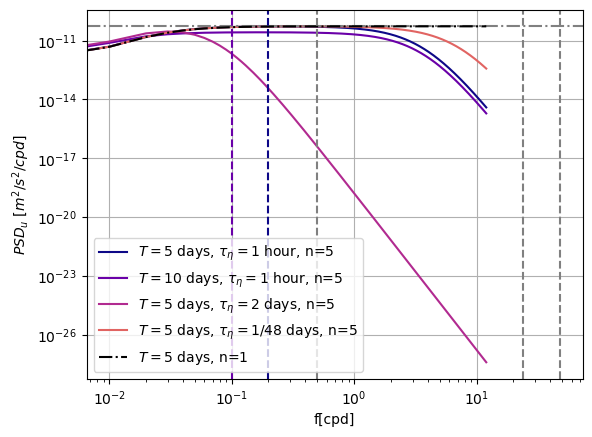

In [10]:
ds.PSDa.sel(T=5, tau_eta=1/24).plot(color = colors[0],label=r'$T=5$ days, $\tau_{\eta}=1$ hour, n=5')
ds.PSDa.sel(T=10, tau_eta=1/24).plot(color = colors[1],label=r'$T=10$ days, $\tau_{\eta}=1$ hour, n=5')
ds.PSDa.sel(T=5, tau_eta=2).plot(color = colors[2],label=r'$T=5$ days, $\tau_{\eta}=2$ days, n=5')
ds.PSDa.sel(T=5, tau_eta=1/48).plot(color = colors[3],label=r'$T=5$ days, $\tau_{\eta}=1/48$ days, n=5')
plt.axhline(2/5/(86400**2), ls='-.', color='grey')
ds.PSDa_exp.sel(T=5).plot(color = 'k', ls='-.', label=r'$T=5$ days, n=1')

plt.axvline(1/5, ls='--', color = colors[0])
plt.axvline(1/10, ls='--', color = colors[1])
plt.axvline(24, ls='--', color = 'grey')
plt.axvline(1/2, ls='--', color = 'grey')
plt.axvline(48, ls='--', color = 'grey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f[cpd]')
plt.ylabel(r'$PSD_u$ $[m^2/s^2/cpd]$')
plt.grid()
plt.legend()
plt.title('')

________
# Generated times series VS theorical functions

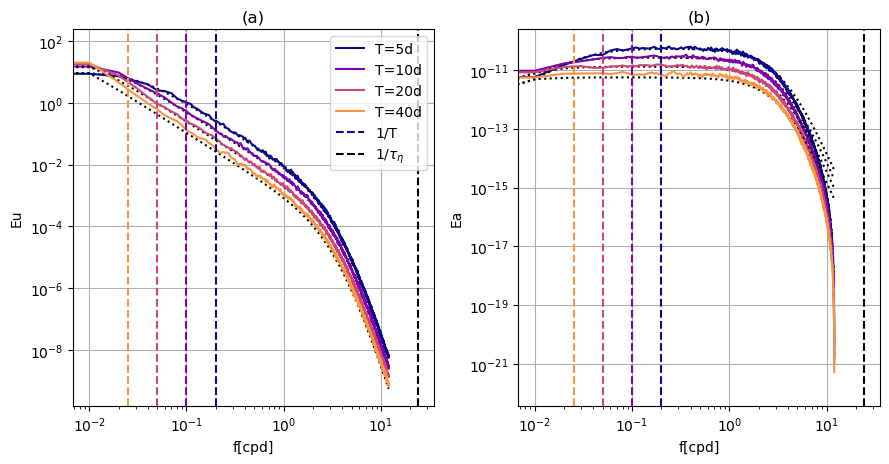

In [11]:
fplt.plot_psd(ds.sel(tau_eta=1/24));

In [6]:
ds.cora_inf.isel(T=0, tau_eta=1)

<xarray.DataArray 'cora_inf' (lags: 24000)>
array([ 4.83372943e-020,  3.74879561e-020,  1.73343293e-020, ...,
       -1.02817957e-108, -1.01964701e-108, -1.01118525e-108])
Coordinates:
    T        int64 5
  * lags     (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
    tau_eta  float64 0.04167

In [7]:
ds.aa.isel(T=0, tau_eta=1).mean('draw').compute()

<xarray.DataArray 'aa' (lags: 24000)>
array([2.04185253e-10, 1.87896859e-10, 1.47701784e-10, ...,
       1.65531626e-14, 1.26699856e-14, 6.72184519e-15])
Coordinates:
    T        int64 5
  * lags     (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
    tau_eta  float64 0.04167

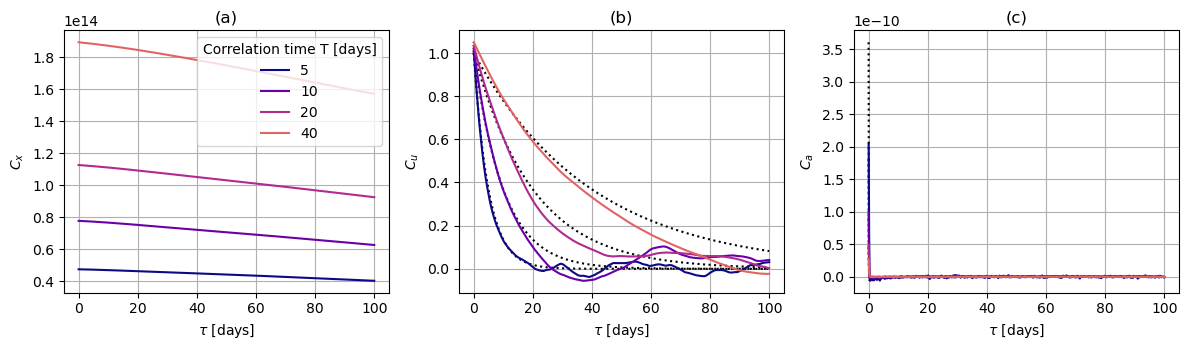

In [15]:
fplt.plot_autocorrelations(ds.sel(tau_eta=1/24).mean('draw'), tau_max=100);

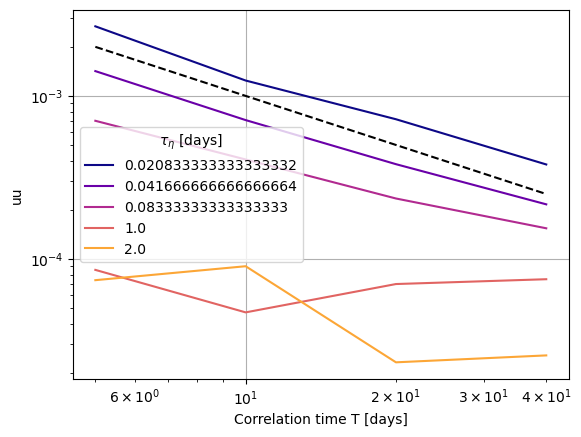

In [15]:
(1-ds['uu'].sel(lags=1/24)/ds['uu'].sel(lags=0)).mean('draw').plot(hue='tau_eta')
plt.plot(ds.T, 1/ds.T*1e-2, color='k', ls='--')#pente=-1
plt.xscale('log')
plt.yscale('log')
plt.grid()

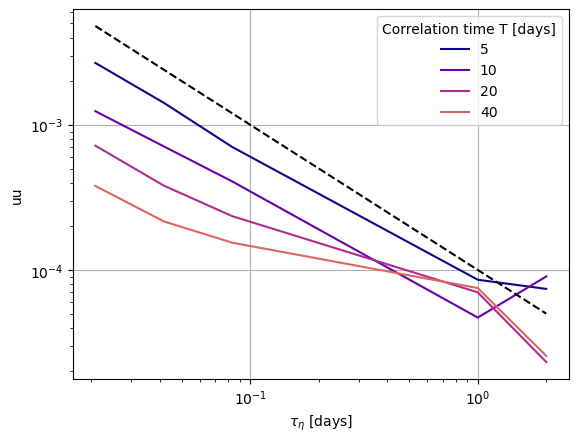

In [14]:
(1-ds['uu'].sel(lags=1/24)/ds['uu'].sel(lags=0)).mean('draw').plot(hue='T')
plt.plot(ds.tau_eta, 1/ds.tau_eta*1e-4, color='k', ls='--')#pente=-1
plt.xscale('log')
plt.yscale('log')
plt.grid()

________
## Verify Parseval -> Parseval ok

In [13]:
(ds.u**2).mean(['time', 'draw']).compute()

<xarray.DataArray 'u' (T: 4, tau_eta: 5)>
array([[1.01052109, 1.00808226, 1.01799807, 1.01204778, 1.00373331],
       [1.0165745 , 1.02161354, 1.02273136, 1.01370769, 1.05223935],
       [1.04492094, 1.03365049, 1.03086442, 1.03058722, 1.11677702],
       [1.10590197, 1.04982833, 1.0540301 , 1.15627638, 1.17796387]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [14]:
ds.Eu.integrate("freq_time").mean('draw').compute()

<xarray.DataArray 'Eu' (T: 4, tau_eta: 5)>
array([[1.02532243, 1.00157433, 1.01341786, 1.00358339, 0.97352961],
       [1.01422262, 1.0372059 , 1.00059265, 1.01795051, 1.05956469],
       [1.06127049, 1.00948604, 1.00517829, 1.03898462, 1.15484949],
       [1.10321231, 1.03926525, 1.0258308 , 1.15293504, 1.21970258]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [15]:
ds.PSDu.integrate("freq_time").compute()

<xarray.DataArray 'PSDu' (T: 4, tau_eta: 5)>
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [16]:
(ds.a**2).mean(['time', 'draw']).compute()

<xarray.DataArray 'a' (T: 4, tau_eta: 5)>
array([[3.56053793e-10, 2.04185253e-10, 9.97604403e-11, 6.67593350e-12,
        3.01053800e-12],
       [1.64961429e-10, 9.97492332e-11, 5.22659444e-11, 4.34671387e-12,
        1.85969870e-12],
       [9.66082443e-11, 4.95368063e-11, 2.65794772e-11, 2.26380484e-12,
        1.09706102e-12],
       [5.00158989e-11, 2.71247644e-11, 1.32792296e-11, 1.18298368e-12,
        6.82021108e-13]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [17]:
ds.Ea.integrate("freq_time").mean('draw').compute()

<xarray.DataArray 'Ea' (T: 4, tau_eta: 5)>
array([[3.54778879e-10, 2.04140080e-10, 9.99016340e-11, 6.62256133e-12,
        2.99252260e-12],
       [1.64925039e-10, 9.98371235e-11, 5.20345055e-11, 4.30597021e-12,
        1.84448700e-12],
       [9.65461614e-11, 4.95260567e-11, 2.65868492e-11, 2.25869789e-12,
        1.11407713e-12],
       [4.99327572e-11, 2.71138631e-11, 1.32382517e-11, 1.19479820e-12,
        6.76545646e-13]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [18]:
ds.PSDa.integrate("freq_time").compute()

<xarray.DataArray 'PSDa' (T: 4, tau_eta: 5)>
array([[3.98455553e-10, 1.99239632e-10, 9.87955939e-11, 6.91096876e-12,
        2.90991030e-12],
       [1.99635003e-10, 1.00030362e-10, 4.98088002e-11, 3.79275358e-12,
        1.72726172e-12],
       [9.85881275e-11, 4.94467981e-11, 2.46693475e-11, 1.95624521e-12,
        9.26492409e-13],
       [4.23884868e-11, 2.12625555e-11, 1.06107442e-11, 8.44886450e-13,
        4.00561908e-13]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0